# Axon Segmentation Analysis of Whole-Brain Light-Sheet Images

In [31]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.util import json_to_points, download_subvolumes
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from brainlit.BrainLine.imports import *
from brainlit.BrainLine.apply_ilastik import (
    ApplyIlastik,
    ApplyIlastik_LargeImage,
    plot_results,
    examine_threshold
)
from brainlit.BrainLine.analyze_results import (
    AxonDistribution,
    collect_regional_segmentation,
)
from scipy.special import rel_entr
from itertools import combinations
import networkx as nx
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind

%gui qt5

## 1. Before Using this notebook:

### 1a. Install brainlit, and other packages that this notebook uses
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
        ,
    {
    "type":"pointAnnotation",
    "name": "val",
    "points": []
    }
### 1d. Update axon_data.py file

### \*Inputs\*

In [32]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[1]
print(f"Path to brainlit: {brainlit_path}")
data_file = brainlit_path / "experiments" / "BrainLine" / "data" / "axon_data.json"

with open(data_file) as f:
    data = json.load(f)
brain2paths = data["brain2paths"]


brain = "MS32"  # brain ID
axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"  # path to directory where training/validation data should be stored

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit


## 2. Download benchmark data

### \*Inputs\*

In [26]:
antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

dataset_to_save = "val"  # train or val

In [27]:
cvol_base = brain2paths[brain]["base"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

### Download data

In [28]:
download_subvolumes(
    axon_data_dir,
    brain_id=brain,
    layer_names=layer_names,
    dataset_to_save=dataset_to_save,
    data_file=data_file,
)

fg shape: (7471, 10298, 4200, 1) at [1830. 1830. 2000.]
bg shape: (7471, 10298, 4200, 1) at [1830. 1830. 2000.]
endo shape: (7471, 10298, 4200, 1) at [1830. 1830. 2000.]
[11] centers
Downloaded data will be stored in /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS32/val


Saving samples:  45%|████▌     | 5/11 [01:33<01:52, 18.70s/it]


BlockingIOError: [Errno 35] Unable to create file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_775_4829_2459.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_2channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply Ilastik to validation data

You will need to do two things:
- add annotations to the downloaded data (for me, partial labels on 3 of the z-slices using ilastik)
- apply axon segmentation model to the downloaded data. Results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names: you can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

Note: make sure foreground/background labels are matched between the model and your annotations (for me, blue/1 =axon yellow/0=bg)

In [12]:
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp"  # path to ilastik model to be used
ilastik_path = (
    "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
)
brains = [brain]
# brains = ["8650", "8613", "8589", "8788", "8786", "8790", "MS32", "MS29", "MS11", "MS15", "11537"]

In [14]:
applyilastik = ApplyIlastik(
    ilastik_path=ilastik_path,
    project_path=project_path,
    brains_path=axon_data_dir,
    brains=brains,
)
applyilastik.process_subvols()

running ilastik...: 100%|██████████| 10/10 [00:00<00:00, 48.84it/s]


## 5. Check results

Processing Brains: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]

If this performance is not adequate, improve model and try again
Brain MS33 Validation: 3154+ 9284-


(<Figure size 576x576 with 1 Axes>, 0.958583623142586, 0.18)

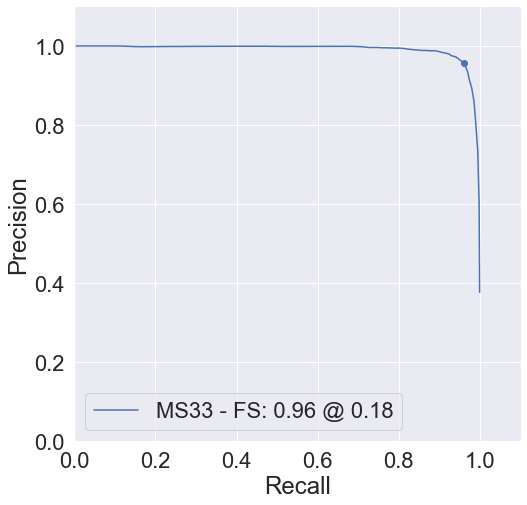

In [17]:
plot_results(
    data_dir=axon_data_dir, brain_ids=[brain], object_type="axon", positive_channel=1
)

### If results above are not adequate improve the model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.


### Examine best threshold

In [18]:
examine_threshold(
    data_dir=axon_data_dir,
    brain_id=brain,
    threshold=0.18,
    object_type="axon",
    positive_channel=1,
)

*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/2281_6823_1714.h5*********
prec0.7857142857142857 recall: 0.9565217391304348
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/4557_5807_2143.h5*********
Precision: 0.9664570230607966, recall: 0.9725738396624473
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/4216_9061_2238.h5*********
prec0.6428571428571429 recall: 0.8181818181818182
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/4537_3455_2143.h5*********
Precision: 1, recall: 1
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/6385_6086_1844.h5*********
prec0.0 recall: 1
*************File: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brainMS33/val/3078_8198_2143.h5*********
Precision: 0.987012987012987, re

### Paper figure for all validation

Processing Brains:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Brains: 100%|██████████| 11/11 [00:41<00:00,  3.76s/it]


If this performance is not adequate, improve model and try again
Brain 11537 Validation: 613+ 10762-


(<Figure size 576x576 with 1 Axes>, 0.9080459770114943, 0.88)

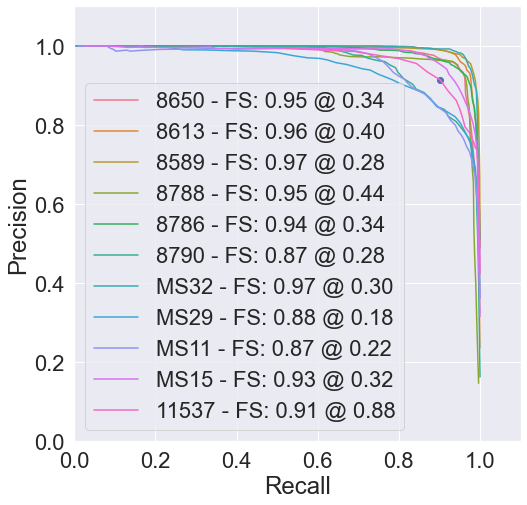

In [18]:
brain_ids = [
    "8650",
    "8613",
    "8589",
    "8788",
    "8786",
    "8790",
    "MS32",
    "MS29",
    "MS11",
    "MS15",
    "11537",
]

plot_results(
    data_dir=axon_data_dir,
    brain_ids=brain_ids,
    object_type="axon",
    positive_channel=1,
)

## 6. Make annotation layers

### Axon segmentation

In [ ]:
if "base" in brain2paths[brain].keys():
    dir = brain2paths[brain]["base"] + "axon_mask"
else:
    dir = brain2paths[brain]["mask"]

try:
    CloudVolume(dir)
except:
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="segmentation",
        data_type="uint64",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=vol_bg.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=vol_bg.voxel_offset,  # x,y,z offset in voxels from the origin
        # mesh            = 'mesh',
        # Pick a convenient size for your underlying chunk representation
        # Powers of two are recommended, doesn't need to cover image exactly
        chunk_size=[128, 128, 2],  # units are voxels
        volume_size=vol_bg.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(dir, info=info)
    vol_mask.commit_info()

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
    "axon_mask",
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image:

### \* Inputs \*

You can use the notebook code below or the script using `axon_segment_image.py`

In [ ]:
brain = "test"
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

threshold = 0.12  # threshold to use for ilastik
data_dir = (
    str(Path.cwd().parents[0]) + "/brain_temp/"
)  # data_dir = "/data/tathey1/matt_wright/brain_temp/"  # directory to store temporary subvolumes for segmentation

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"  # "/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp"  # "/data/tathey1/matt_wright/ilastik/model1/axon_segmentation.ilp"  # path to ilastik project


max_coords = [
    3072,
    4352,
    1792,
]  # max coords or -1 if you want to process everything along that dimension
ncpu = 1  # 16  # number of cores to use for detection
chunk_size = [256, 256, 256]  # [256, 256, 300]

In [ ]:
layer_names = [antibody_layer, background_layer, endogenous_layer]
alli = ApplyIlastik_LargeImage(
    ilastik_path=ilastik_path,
    ilastik_project=ilastik_project,
    ncpu=ncpu,
    object_type="axon",
)
alli.apply_ilastik_parallel(
    brain_id=brain,
    layer_names=layer_names,
    threshold=threshold,
    data_dir=data_dir,
    chunk_size=chunk_size,
    max_coords=max_coords,
)
alli.collect_axon_results(brain_id=brain, ng_layer_name="127.0.0.1:9010")

## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 



A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_09_18/MS33/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_09_18/MS33/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RAI --rotation 5 0 0 --translation 0 0 0 --fixed_scale 1.05 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_09_18/MS33/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform segmentation to atlas space using CloudReg

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/2023_04_07/MS29_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2023_04_07/MS29_Ch_561_registration/downloop_1_v.mat
```

python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_10_26/11537/axon_mask_transformed --affine_path /cis/home/tathey/11537_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/11537_Ch_561_registration/downloop_1_v.mat

This will write a layer to s3 with the transformed axon mask. The s3 path to this layer should be added to `axon_data.py` under the `axon_mask_transformed` key. Then the code below, or `axon_brainrender.py`, can be used to visualize the data.

## 9. Combine registration and segmentation results

In [ ]:
collect_regional_segmentation(
    brain_id=brain,
    outdir=axon_data_dir,
    max_coords=[
        6029,
        -1,
        -1,
    ],
)

## 10. View coronal heat maps

### \*Inputs\*

In [53]:
brain_ids = [
    # "3",
    # "4",
    "8613",
    # "8604",
    "8650",
    "8589",
    # "8590",
    # "8649",
    "8788",
    "8786",
    # "11537", # transformed mask not found
    "8790",
    "MS32",
    "MS29",
    "MS11",
    "MS15",
    # "MS12" # no transformed mask yet
    "MS33",
]  # list of sample IDs to be shown


colors = {
    "tph2 gad2": "red",
    "tph2 vglut3": "blue",
    "gad2 vgat": "green",
}  # colors for different genotypes
fold_on = False
ontology_file = brainlit_path / "BrainLine" "data" / "ara_structure_ontology.json"

axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/"

ad = AxonDistribution(
    brain_ids=brain_ids,
    regional_distribution_dir=axon_data_dir,
    data_file=data_file,
    ontology_file=ontology_file,
)

In [ ]:
ad.napari_coronal_section(z=1200, subtype_colors=colors, fold_on=True)

In [ ]:
z_size = 1320
for z in tqdm(np.arange(250, z_size, 250)):
    ad.napari_coronal_section(z=z, subtype_colors=colors, fold_on=fold_on)

In [ ]:
dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/matt-coronals/"
z_size = 1320

for z in tqdm(np.arange(50, z_size, 50)):
    fname = dir + f"{brain}_{z}_axon.tif"
    v = ad.napari_coronal_section(z=z, subtype_colors=colors, fold_on=False)
    im = v.screenshot(canvas_only=False)
    io.imsave(fname, im)

## 11. Display bar charts

In [54]:
regions_coarse = [
    688,
    1097,
    549,
    354,
    512,
    477,
    1089,
    313 # midbrain
]


regions_fine = [
    95,  # agranular insular area
    714,  # orbital area
    972,  # prelimbic
    44,  # infralimbic
    186,  # lateral habenula
    149, #paraventricular nucleus of thalamus (part of polymodal assoc cortex)
    864, # sensorimotor thalamus
    519, #cerebellar nuclei
    528, #cerebellar cortex
    290,  # hypothalamic lateral zone
    141, #periventricular region (preoptic nuclei)
    946, #posterior hypothalamic nucleus
    797,  # zona incerta
    331,  # mammillary body
    364, #parasubthalamic nucleus
    38, #paraventricular hypothalamic nucleus
    223, #arcuate hypothalamic nucleus
    80, #anterior hypothal nucleus
    830, #dorsomedial hypothal nuc.
    693, #ventromedial hypothal nuc.
    470, #subthalamic n
    286, #suprachiasmatic n
    351,  # bed nuclei of stria terminalis
    536, #central amygdala
    323, #midbrain - motor
    339, #midbrain - sensory
    348, #midbrain - behavioral state
]

regions = [
    500, # somatomotor
    453, # somatosensory
    972,  # prelimbic
    44,  # infralimbic
    477,
    1089,
    1097, # hypothalamus
    549, # thalamus
    186,  # lateral habenula
    351,  # bed nuclei of stria terminalis
    313, # midbrain
    512, # cerebellum
    354, # medulla
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdala": [131, 295, 319, 536, 780],
    #"Substantia Nigra": [615, 374, 374],
    #"Superior Colliculus": [294, 302],
}  # Custom composite allen regions where key is region name and value is list of allen regions

#### Are regions mutually exclusive?

In [ ]:
regions = regions_coarse_part
for r_src in regions:
    print(sd.region_graph.nodes[r_src]['name'])
    for r_targ in regions:
        if r_targ == r_src:
            continue
        elif nx.has_path(sd.region_graph, r_src, r_targ):
            print(f"{r_src} is parent of {r_targ}")

#### Normality test

In [ ]:
from scipy.stats import shapiro

DG = ad.region_graph

for region in regions:
    for subtype in colors.keys():
        data = []
        for brain in brain_ids:
            if brain2paths[brain]["subtype"] == subtype:
                total = DG.nodes[997][f"{brain} axon"]
                data.append(np.log(DG.nodes[region][f"{brain} axon"] / total))

        if len(data) > 2:
            _, p = shapiro(data)
            if p < 0.05:
                plt.hist(data)
                plt.title(f"{subtype} - {DG.nodes[region]['name']}: p={p}")
                plt.show()

#### Simple boxplot

In [55]:
def _log_ttest_ind(group_data1, group_data2, verbose=1, **stats_params):
    group_data1_log = np.log(group_data1)
    group_data2_log = np.log(group_data2)

    return ttest_ind(group_data1_log, group_data2_log, **stats_params)

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters pass

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Somatosensory areas_tph2 gad2 (n=4) vs. Somatosensory areas_gad2 vgat (n=2): Log t-test_ind with Benjamini-Hochberg correction, P_val:6.698e-01 Stat=4.594e-01
Prelimbic area_tph2 gad2 (n=4) vs. Prelimbic area_gad2 vgat (n=2): Log t-test_ind with Benjamini-Hochberg correction, P_val:nan Stat=nan
Prelimbic area_tph2 vglut3 (n=5) vs. Prelimbic area_tph2 gad2 (n=4): Log t-test_ind with Benjamini-Hochberg correction, P_val:nan Stat=nan
Infralimbic area_tph2 gad2 (n=4) vs. Infralimbic area_gad2 vgat (n=2): Log t-test_ind with Benjamini-Hochberg correction, P_val:nan Stat=nan
Infralimbic area_tph2 vglut3 (n=5) vs. Infralimbic area_tph2 gad2 (n=4): Log t-test_ind with Benjamini-Hochberg correction, P_val:nan Stat=nan
Striatum_tph2 gad2 (n=4) vs. Striatum_gad2 vgat (n=2): Log t-test_ind with Benjamini-Hochberg correc

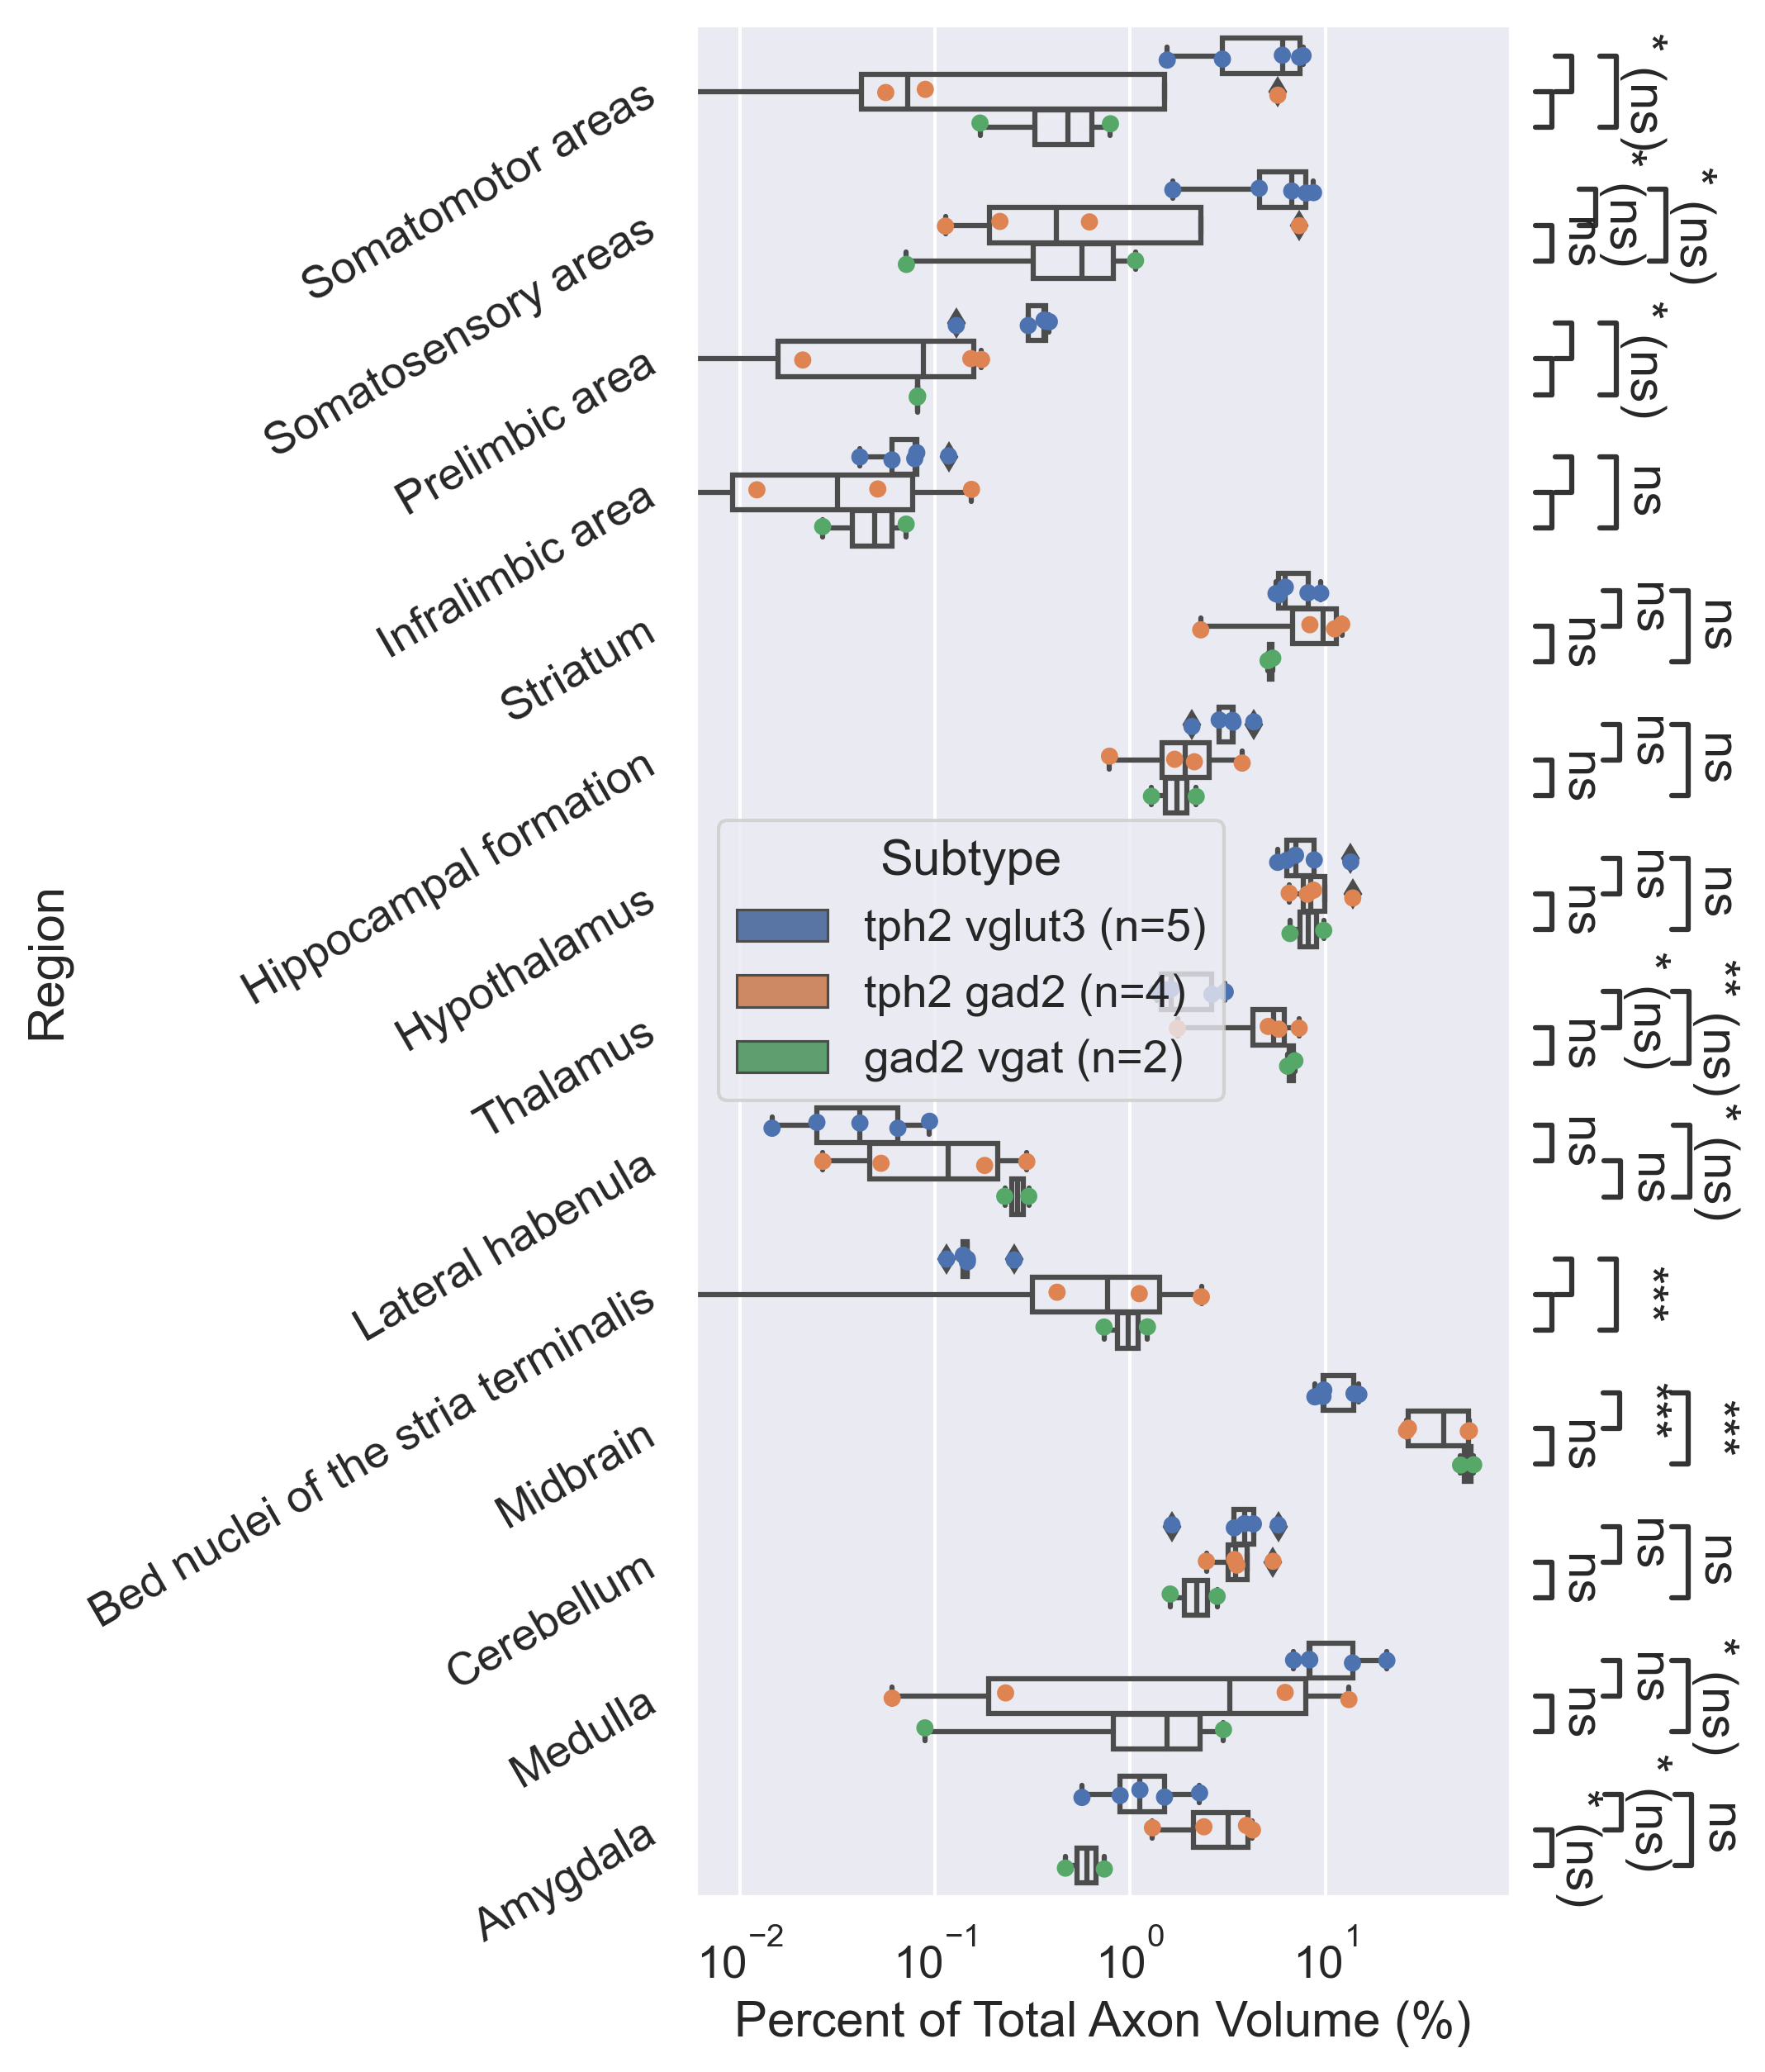

In [56]:
test = StatTest(_log_ttest_ind, test_long_name='Log t-test_ind', test_short_name='log-t')
#test = "Mann-Whitney"
#test = "t-test_ind"

region_names = []
pcts = []
ids = []
subtypes = []
subtype_counts = {}

for brain_id in ad.brain_ids:
    subtype = ad.brain2paths[brain_id]["subtype"]
    if subtype in subtype_counts.keys():
        subtype_counts[subtype] = subtype_counts[subtype] + 1
    else:
        subtype_counts[subtype] = 1

    for region in regions:
        pct = ad.region_graph.nodes[region][f"{brain_id} axon"]/ad.region_graph.nodes[997][f"{brain_id} axon"]*100
        
        pcts.append(pct)
        subtypes.append(subtype)
        ids.append(brain_id)
        region_names.append(ad.region_graph.nodes[region]["name"])
    for composite_region in composite_regions.keys():
        composite_region_regions = composite_regions[composite_region]
        total = 0
        for region in composite_region_regions:
            total += ad.region_graph.nodes[region][f"{brain_id} axon"]
        pcts.append(total/ad.region_graph.nodes[997][f"{brain_id} axon"]*100)
        subtypes.append(subtype)
        ids.append(brain_id)
        region_names.append(composite_region)


# append n to subtypes
for i, subtype in enumerate(subtypes):
    subtypes[i] = subtype + f" (n={subtype_counts[subtype]})"
        
data = {"Region": region_names, "Brain ID": ids, "Subtype": subtypes, "Percent of Total Axon Volume (%)": pcts}
df = pd.DataFrame(data=data)

diffs = []
for region_name in df["Region"].unique():
    diff = df[(df["Region"] == region_name) & (df["Subtype"] == "tph2 gad2")]["Percent of Total Axon Volume (%)"].mean() - df[(df["Region"] == region_name) & (df["Subtype"] == "tph2 vglut3")]["Percent of Total Axon Volume (%)"].mean()
    diffs.append((region_name, diff))
def second(e):
    return e[1]
diffs.sort(key=second, reverse=False)
order = [e[0] for e in diffs]

sns.set(font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(8,8.6), dpi=300)
fig_args = {
            "x": "Percent of Total Axon Volume (%)",
            "y": "Region",
            "hue": "Subtype",
            "data": df,
            "dodge": True,
        }
bplot = sns.stripplot(ax=ax, legend=False, order=order, **fig_args)
fig_args["boxprops"] = {'facecolor':'none'}
bplot = sns.boxplot(ax=ax, order=order, **fig_args)
bplot.set_xscale("log")
tick_labels = bplot.get_yticklabels()
bplot.set_yticklabels(labels=tick_labels, rotation=30)

#annotator
fig_args["x"] = "Region"
fig_args["y"] =  "Percent of Total Axon Volume (%)"
pairs = []
unq_subtypes = np.unique(subtypes)
for region in regions + ["Amygdala"]:
    if region == "Amygdala":
        region_name = region
    else:
        region_name = ad.region_graph.nodes[region]["name"]

    for i, subtype1 in enumerate(unq_subtypes):
        for subtype2 in unq_subtypes[i+1:]:
            pairs.append(((region_name, subtype1), (region_name, subtype2)))
annot = Annotator(ax, pairs, **fig_args)
annot.configure(test=test, text_format="star", loc="outside", comparisons_correction="BH")
fig_args["y"] = "Region"
fig_args["x"] =  "Percent of Total Axon Volume (%)"
annot.new_plot(bplot, orient="h", plot="boxplot", **fig_args)
annot.apply_and_annotate()

# markers = ["o", "v", "^", "<", ">", "s", "p", "*", "+", "x"]
# jitters = {"tph2 vglut3": -0.26, "tph2 gad2": 0, "gad2 vgat": 0.26}
# id2marker = {id: markers[idx] for idx, id in enumerate(brain_ids)}
# for idx, line in df.iterrows():
#     st = line["Subtype"].split("(")[0][:-1]

#     x = line["Percent of Total Axon Volume (%)"]
#     y = order.index(line["Region"]) + jitters[st]
#     c = colors[st]
#     marker = id2marker[line["Brain ID"]]
#     ax.scatter([x], [y], c=c, marker=marker)


fig.tight_layout()

In [47]:
with open("/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/wholebrain_MS33.pkl", "rb") as f:
    q_dict = pickle.load(f)

In [52]:
for k in q_dict.keys():
    try:
        print(f"{ad.region_graph.nodes[k]['name']}: {float(q_dict[k][1])/float(q_dict[k][0])}")
    except:
        pass

Pontine reticular nucleus: 0.04393016837288345
pyramid: 0.002027733998774188
Nucleus raphe magnus: 0.034264703923710074
Nucleus raphe pallidus: 0.0017760758915069698
Magnocellular reticular nucleus: 0.041857745125048515
Medulla: 0.005124936294624359
Tegmental reticular nucleus: 0.0048959809817214215
Nucleus of the trapezoid body: 0.005044481827578206
medial lemniscus: 0.02749478373698733
Pons: 0.018147647704327505
corticospinal tract: 0.0042876386734358105
trapezoid body: 0.002617042154633372
crossed tectospinal pathway: 0.03397624700317739
Gigantocellular reticular nucleus: 0.03457452825124487
Parapyramidal nucleus: 0.01586990077663287
Pontine reticular nucleus, caudal part: 0.04242464071958109
third ventricle: 0.02083335492487525
Retrosplenial area, dorsal part, layer 6a: 0.0011414550731934814
Retrosplenial area, lateral agranular part, layer 6b: 0.0007816128532847092
Midbrain: 0.05497644447639243
Retrosplenial area, dorsal part, layer 6b: 0.0013633247465514376
Field CA1: 0.002068202

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind

for region in df.Region.unique():
    for i, subtype1 in enumerate(df.Subtype.unique()):
        for j, subtype2 in enumerate(df.Subtype.unique()[i+1:]):
            l1 = df[(df["Region"] == region) & (df["Subtype"] == subtype1)]["Percent of Total Axon Volume (%)"].tolist()
            l2 = df[(df["Region"] == region) & (df["Subtype"] == subtype2)]["Percent of Total Axon Volume (%)"].tolist()

            _, p = _log_ttest_ind(l1, l2)
            for i in range(10):
                if p > 0.0047:
                    if len(l1) > len(l2):
                        l2.append(np.median(l2))
                    else:
                        l1.append(np.median(l1))
                else:
                    break
                
                _, p = _log_ttest_ind(l1, l2)
            print(f"{region}: {subtype1} vs {subtype2}: need {i} more added")

In [ ]:
ad.region_barchart(
    regions=regions_coarse, composite_regions=composite_regions, normalize_region=872
)

### PCA

In [14]:
region_graph.nodes[region]

{
    'level': 3,
    'st_level': 3,
    'name': 'Cerebral cortex',
    'acronym': 'CTX',
    'label': '3) Cerebral cortex',
    '8613 axon': 246892528.0,
    '8613 total': 12037752896.0,
    '8650 axon': 24787682.0,
    '8650 total': 12110235840.0,
    '8589 axon': 310340846.0,
    '8589 total': 15261029184.0,
    '8788 axon': 69141411.0,
    '8788 total': 47528264512.0,
    '8786 axon': 351731515.0,
    '8786 total': 45482665856.0,
    '8790 axon': 155674134.0,
    '8790 total': 58148295104.0,
    'MS32 axon': 43683831.0,
    'MS32 total': 40555102592.0,
    'MS29 axon': 9051614.0,
    'MS29 total': 42963452736.0,
    'MS11 axon': 26307779.0,
    'MS11 total': 38840879104.0,
    'MS15 axon': 102637691.0,
    'MS15 total': 36103075520.0
}

Text(0.5, 1.0, 'Input Distribution PCA with Explained Variance: [0.87494079 0.10841842]')

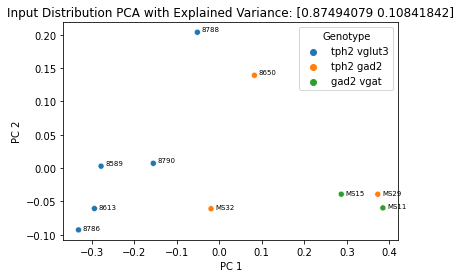

In [15]:
brain2paths = ad.brain2paths
region_graph = ad.region_graph

data_mat = np.zeros((len(brain_ids), len(regions_coarse)))


for bn, brain_id in enumerate(brain_ids):
    for rn, region in enumerate(regions_coarse):
        data_mat[bn, rn] = region_graph.nodes[region][brain_id + " axon"]/region_graph.nodes[997][brain_id + " axon"]

pca = PCA(n_components=2)
X_2 = pca.fit_transform(data_mat)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": [brain2paths[brain_id]["subtype"] for brain_id in brain_ids],
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    sign = 2*(df_pca["PC 2"][i] > 0) - 1
    plt.text(
        x=df_pca["PC 1"][i] + 0.01,
        y=df_pca["PC 2"][i] + sign*0.001,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=7),
    )

plt.title(
    f"Input Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## Other stats

### Partition regions

In [ ]:
regions = [
    688,  # cerebral cortex
    477,  # striatum
    351,  # bed nuclei of stria terminalis
    1097,  # hypothalamus
    549,  # thalamus
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown

regions = [
    95,  # agranular insular area
    714,  # orbital area
    698,  # olfactory areas
    1089,  # hippocampal formation
    477,  # striatum
    803,  # pallidum
    703,  # cortical subplate
    157,  # periventricular zone
    515,  # medial preoptic nucleus
    290,  # hypothalamic lateral zone
    331,  # mammillary body
    549,  # thalamus
    519,  # cerebellar nuclei
    157,  # inferior colliculus
    1052,  # pedunculopontine
    128,  # midbrain reticular nucleus
    214,  # red nucleus
    867,  # parabrachial nucleus
    701,  # vestibular nuclei
    972,  # prelimbic
    44,  # infralimbic
]  # allen atlas region IDs to be shown

In [ ]:
for r_src in regions:
    for r_targ in regions:
        if r_targ == r_src:
            continue
        elif nx.has_path(ad.region_graph, r_src, r_targ):
            print(f"{r_src} is parent of {r_targ}")

### KL Div permutation test

In [ ]:
def get_dist(brain_id, regions, sd):
    bkey = f"{brain_id} axon"
    total = ad.region_graph.nodes[997][bkey]
    dist = []
    for region in regions:
        dist.append(ad.region_graph.nodes[region][bkey])
    dist.append(total - np.sum(dist))

    return np.divide(dist, total)

In [ ]:
fig, axs = plt.subplots(1, 3)

for i, (stype1, stype2) in enumerate(
    zip(
        ["tph2 gad2", "tph2 gad2", "tph2 vglut3"],
        ["tph2 vglut3", "gad2 vgat", "gad2 vgat"],
    )
):
    ax = axs[i]
    brain_ids_stypes = []
    sz = 0
    dists = []

    for brain in brain_ids:
        if ad.brain2paths[brain]["subtype"] == stype1:
            dist = get_dist(brain, regions, ad)
            dists.append(dist)
            brain_ids_stypes.append(brain)
            sz += 1
    av_dist1 = np.mean(np.array(dists), axis=0)

    dists = []
    for brain in brain_ids:
        if ad.brain2paths[brain]["subtype"] == stype2:
            dist = get_dist(brain, regions, ad)
            dists.append(dist)
            brain_ids_stypes.append(brain)
    av_dist2 = np.mean(np.array(dists), axis=0)

    kl_div_true = np.sum(rel_entr(av_dist1, av_dist2)) + np.sum(
        rel_entr(av_dist2, av_dist1)
    )
    if not np.isfinite(kl_div_true) or kl_div_true < 0:
        print(av_dist1)
        print(av_dist2)
    kl_divs = []

    for combo in tqdm(combinations(brain_ids_stypes, sz)):
        dists = []
        for brain in combo:
            dist = get_dist(brain, regions, ad)
            dists.append(dist)
        av_dist1 = np.mean(np.array(dists), axis=0)

        dists = []
        for brain in brain_ids:
            if brain not in combo:
                if (
                    ad.brain2paths[brain]["subtype"] == stype1
                    or ad.brain2paths[brain]["subtype"] == stype2
                ):
                    dist = get_dist(brain, regions, ad)
                    dists.append(dist)
        av_dist2 = np.mean(np.array(dists), axis=0)

        kl_div_c = np.sum(rel_entr(av_dist1, av_dist2)) + np.sum(
            rel_entr(av_dist2, av_dist1)
        )

        if not np.isfinite(kl_div_c) or kl_div_c < 0:
            print(av_dist1)
            print(av_dist2)
        kl_divs.append(kl_div_c)

    p = np.sum(kl_divs >= kl_div_true) / len(kl_divs)
    ax.hist(kl_divs)
    ax.plot([kl_div_true, kl_div_true], [0, 15], c="r", label=f"pval={p:.2f}")
    ax.set_title(f"{stype1} vs {stype2} w/{len(kl_divs)} permutations")
    ax.set_xlabel("Symmetric KL Divergence")
    ax.set_xlabel("Count")
    ax.legend()
fig.set_figheight(5)
fig.set_figwidth(25)

### Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent Total Axon Volume (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## 13. Compare to Allen

### \* Inputs \*

In [ ]:
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # allen atlas region IDs to be shown https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

#### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

#### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(brainlit_path / "brainlit" / "lsm_analysis" / "data" / "sert_exp.xml")
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()

In [ ]:
from brainlit.BrainLine.util import find_sample_names
import h5py
import numpy as np

base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"

brains = [
    "3",
    "4",
    "887",
    "8589",
    "8590",
    "8590_v2",
    "8604",
    "8612",
    "8613",
    "8649",
    "8650",
    "8786",
    "8788",
    "8790",
    "11537",
]

for brain in brains:
    brain_dir = base_dir + "brain" + brain
    files = find_sample_names(brain_dir, dset="", add_dir=True)
    for file in files:
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            print(key)
        #     image = np.array(f.get(key))
        # image = image[[1, 0, 2],:,:,:]
        # with h5py.File(file, "w") as f:
        #     dset = f.create_dataset(key, data=image)

In [ ]:
with h5py.File(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.h5",
    "r",
) as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
    print(image.shape)
    print(np.sum(image))

In [ ]:
import numpy as np

image = np.load(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train_0-image_2channel_Labels.npy"
)
print(image.shape)
print(np.sum(image))

In [ ]:
dir = (
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain4/train/"
)
for file in os.listdir(dir):
    if "Labels" in file:
        file = dir + file
        print(file)
        with h5py.File(file, "r") as f:
            key = list(f.keys())[0]
            image = np.array(f.get(key))
        print(np.sum(image))
        # npy_file = file.split(".")[0] + ".npy"
        # np.save(npy_file, image)

In [ ]:
file = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain3/train/train_31-image_2channel_Labels.h5"
with h5py.File(file, "r") as f:
    key = list(f.keys())[0]
    image = np.array(f.get(key))
npy_file = file.split(".")[0] + ".npy"
np.save(npy_file, image)

In [ ]:
vol = CloudVolume(
    "precomputed://https://dlab-colm.neurodata.io/2022_10_24/8788/axon_mask"
)

In [ ]:
# reg_sub = vol[int(256*11/8):int(256*12/8),int(256*16/8):int(256*17/8), int(256*6:256*7/8)]
atlas_vol = CloudVolume(
    "precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/atlas_to_target"
)
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint64",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=atlas_vol.voxel_offset,
    chunk_size=[32, 32, 32],  # units are voxels
    volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/atlas_to_target",
    info=info,
    compress=False,
)
vol_mask.commit_info()

In [ ]:
vol_mask[
    int(256 * 11 / 8) : int(256 * 12 / 8),
    int(256 * 16 / 8) : int(256 * 17 / 8),
    256 * 6 : 256 * 7,
] = atlas_vol[
    int(256 * 11 / 8) : int(256 * 12 / 8),
    int(256 * 16 / 8) : int(256 * 17 / 8),
    256 * 6 : 256 * 7,
]

In [ ]:
subvol = np.load(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed/subvol.npy"
)
vol = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/axon_mask_transformed",
    compress=False,
)

In [ ]:
vol[30 * 32 : 32 * 32, 7 * 32 : 9 * 32, 16 * 32 : 18 * 32] = subvol

### scratch

In [ ]:
from cloudvolume import CloudVolume

vol = CloudVolume("precomputed://s3://smartspim-precomputed-volumes/2023_05_24/MS29/Ch_561")